# Hyperspectral Images (HSI) Processing

> *Machine Learning and Computational Statistics*  
> *MSc in Data Science, Department of Informatics*  
> *Athens University of Economics and Business*

---

**Hyperspectral Images (HSIs):** An HSI depicts a specific scene at several $(L)$ narrow continuous spectral bands (actually, they visualize the reflectance of the depicted scene in various spectral bands). It can be represented by a $MxNxL$ three dimensional cube, where the first two dimensions correspond to the spatial information, while the third dimension corresponds to the spectral information. Thus, the $(i,j)$ pixel in such an image, $i=1,...,M$, $j=1,...,N$, is represented by an $L$-dimensional vector (constituted by the corresponding spectral bands), called the ***spectral signature*** of the pixel.

![Spectral Signature](./Images/spectral_signature.png)

In several remote sensing applications, the HSIs (taken from satellites) that depict specific scenes of the earth surface at a specific spatial resolution (that is, a single pixel may represent an area from $3x3m^{2}$ to $100x100m^{2}$ or more). That is, each pixel is likely to depict more than one materials depicted in the corresponding area of the scene. Such pixels are called ***mixed pixels*** and they are the vast majority of the pixels in the image. On the other hand, there are (usually) a few pixels that depict a single material. These are called ***pure pixels***.

![Spectral Signature Ground](./Images/mixed_pure_pixels.png)

**Processing in HSIs:** The usual processing procedures in HSIs follow two main directions, namely, the ***spectral unmixing*** and the ***classification***.


(a) ***Spectral Unmixing (SU):*** The problem here is stated as follows: Assume that a set of $m$ spectral signatures corresponding to the pure pixels in the HSI under study is given. For a given pixel in the image, the aim is to determine the percentage (***abundance***) to which each pure material contributes in its formation. It is clear, that SU provides ***sub-pixel information*** for a given pixel. Speaking in mathematical terms, let:

1. $y$ be the (column $L$-dimensional) spectral signature of the pixel under study
        
2. $x_1,...,x_m$ be the spectral signatures (column $L$-dimensional vectors) of the pure pixels in the image (each one corresponding to a pure material met in the image)

3. $θ$, the $m$-dimensional ***abundance vector*** of the pixel (its $q$-th coordinate corresponds to the percentage to which the $q$-th pure pixel contributes to the formation of the pixel under study).



Adopting the ***linear spectral unmixing hypothesis***, the above quantities are related as follows, $y=Xθ+η$, where $η$ is an $L$-dimensional i.i.d., zero mean Gaussian noise vector. Note that, physically, the **entries** of $θ$ should be **non negative** and (ideally) they should **sum to one**.

(b) **(Supervised) Classification:** In this case, the problem is stated as follows: Assume that all pixels in the HSI under study are known to belong to one out of $m$ ***known classes***. Given a specific pixel, the aim is to determine the most suitable class to assign it.

### *Data*

- The data refers to the so called **"Salinas"** HSI, which depicts an area of the Salinas valley in California, USA
- It is a 220x120 spatial resolution HSI and consists of 204 spectral bands (from 0.2μm – 2.4μm) and its spatial resolution is 3.7m
- That is, the HSI is a 220x204 cube
- The data that will be used are in the files ***Salinas_cube.mat*** (the Salinas hypercube) and ***Salinas_gt.mat*** (the class label for each pixel)

## Introduction

### *Libraries* 

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import scipy.io as sio
import scipy.optimize
from scipy.optimize import nnls 
from scipy.optimize import minimize
from sklearn.linear_model import Lasso

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix
from sklearn.base import BaseEstimator

import warnings
warnings.filterwarnings('ignore')

## Part 1

## Spectral Unmixing

The **"Salinas"** HSI includes **7 endmembers**, each one corresponding to a certain material (cultivation in our case), as described in the following table:

| Endmember | Material |
| --------- | -------- |
| 1 | Grapes |
| 2 | Broccoli |
| 3 | Fallow 1 |
| 4 | Fallow 2 |
| 5 | Fallow 3 |
| 6 | Stubble |
| 7 | Celery |

The aim here is to perform **unmixing** on **each one** of the **pixels** in the image **with nonzero label**, with respect to the **7 endmembers**, using the following five different spectral unmixing methods:

- (a) **Least squares**
- (b) **Least squares** imposing the *sum-to-one* constraint
- (c) **Least squares** imposing the *non-negativity* constraint on the entries of ***θ***
- (d) **Least squares** imposing both the *non-negativity* and the *sum-to-one* constraint on the entries of ***θ***
- (e) **LASSO**, i.e., impose sparsity on ***θ*** via L1 norm minimization

For **each method:**
   - Derive the corresponding **7 abundance maps** (one for each endmember / material)
   - Compute the **reconstruction error** (for each, non-zero class label, pixel $y_i$ compute the quantity $\|y_i - Xθ_i\|^2$ and take the average over those pixels)
   
#### Import Data

In [2]:
# Salinas HSI: 220x120x204
Salinas = sio.loadmat('./Data/Salinas_cube.mat')
HSI = Salinas['salinas_cube']

# Endmember's matrix: 204x7
ends = sio.loadmat('./Data/Salinas_endmembers.mat') 
endmembers = ends['salinas_endmembers']

# Ground truth
ground_truth = sio.loadmat('./Data/Salinas_gt.mat')
labels = ground_truth['salinas_gt']

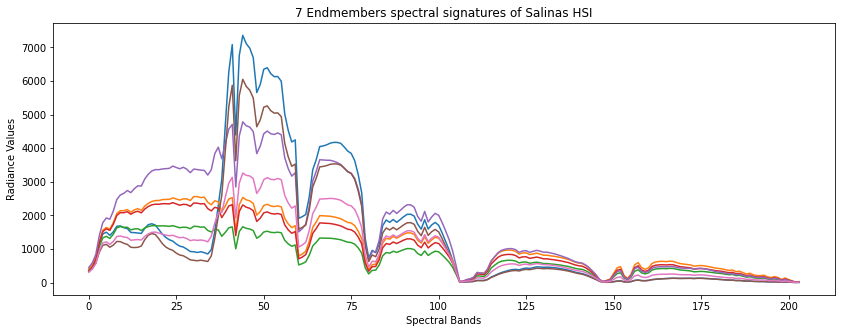

In [3]:
plt.figure(figsize=(14,5))
plt.plot(endmembers)
plt.ylabel('Radiance Values')
plt.xlabel('Spectral Bands')
plt.title('7 Endmembers spectral signatures of Salinas HSI')
plt.show()

### Least Squares

The method of **least squares** is a standard approach in regression analysis to approximate the solution of overdetermined systems (sets of equations in which there are more equations than unknowns) by minimizing the sum of the squares of the residuals (a residual being the difference between an observed value and the fitted value provided by a model) made in the results of each individual equation. More information available [here](https://en.wikipedia.org/wiki/Least_squares).


##### *Define function to get the theta estimates*

- $θ = (X^T X)^{-1} (X^T y)$

In [4]:
def get_thetas(X,Y):
    theta = np.dot(np.linalg.inv(np.dot(X.T,X)), np.dot(X.T,Y))
    return theta

##### *Define function to get the abundance maps (one for each endmember)*

In [4]:
def plot_abundance_maps(thetas, method, x, y):
    # create the figure
    fig, ax = plt.subplots(2,4,figsize=(12,8),dpi=100,facecolor='white')  
    
    #define abundance maps
    abundance_maps = np.zeros((220, 120, 7))

    #for each theta
    for i in range(8):
        # plot ground truth
        if i == 0:
            ax[0,i].imshow(ground_truth['salinas_gt'].reshape(220,120))
            ax[0,i].set_title('Ground Truth')
        # plot endmembers 1-3
        elif i <= 3:
            abundance_maps[x, y, i-1] = thetas[i-1, :]
            ax[0,i].imshow(abundance_maps[:, :, i-1])
            ax[0,i].set_title(f'Endmember {i}')
        # plot endmembers 4-7
        else:
            abundance_maps[x, y, i-1] = thetas[i-1, :]
            ax[1,i-4].imshow(abundance_maps[:, :, i-1])
            ax[1,i-4].set_title(f'Endmember {i}')
    plt.suptitle(method)
    plt.tight_layout(pad=3)
    plt.show()
    return

##### *Define function to compute the reconstruction error*

- $\|y_i - Xθ_i\|^{2}$

In [6]:
def get_reconstruction_error(image, endmembers, labels, thetas):    
    n = np.count_nonzero(labels)
    return np.linalg.norm(image.T - np.dot(endmembers, thetas)) ** 2 / n

##### *Filter-out the pixels with zero label*

In [7]:
X_NZ, Y_NZ = np.nonzero(labels)

NZ_HSI = HSI[X_NZ, Y_NZ]

NZ_HSI.shape

(16929, 204)

In [8]:
LS_thetas = get_thetas(endmembers,NZ_HSI.T)

##### *Get the abundance maps (one for each endmember)*

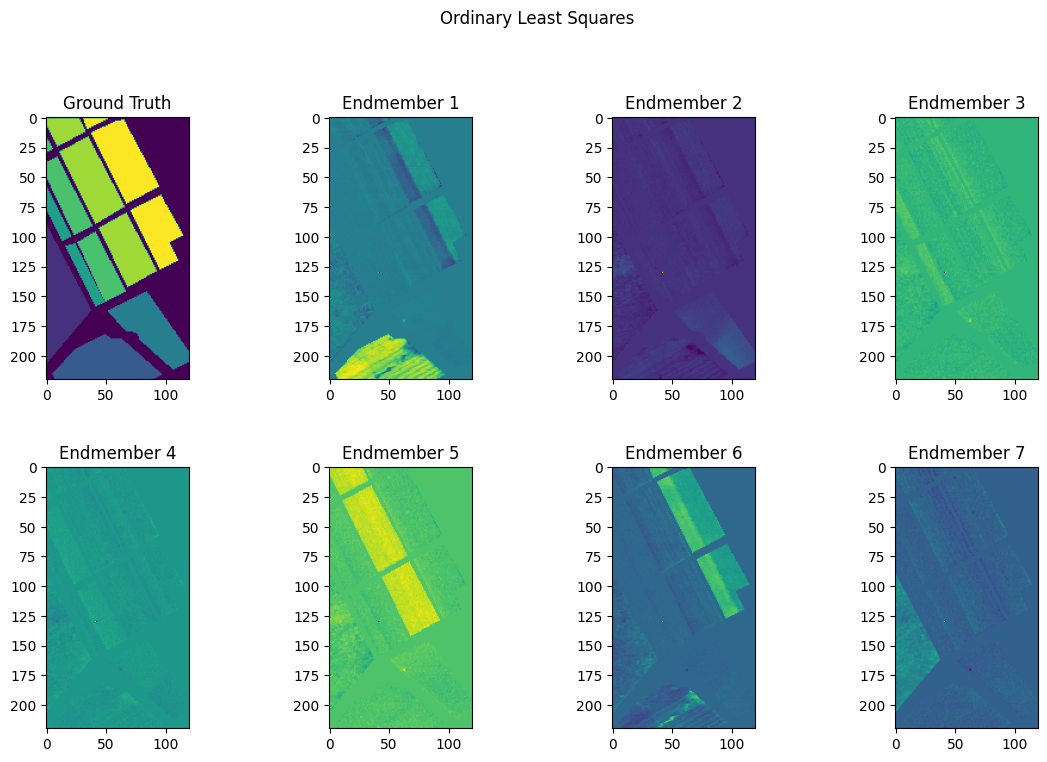

In [9]:
_ = plot_abundance_maps(LS_thetas, 'Ordinary Least Squares', X_NZ, Y_NZ)

In [10]:
LS_Rec_Error = get_reconstruction_error(NZ_HSI,endmembers,labels,LS_thetas)

print(f'LS - Reconstruction Error: {LS_Rec_Error}')

LS - Reconstruction Error: 35058.880662772615


### *(b) Least Squares imposing the sum-to-one constraint*

The **least squares imposing the sum-to-one constraint** is a type of *regularized least squares (RLS)* problem where the regression coefficients should sum to one. To achieve that we need to solve the following problem:

$$ \text{argmin}_{\theta} J(\theta), \phantom{o} \text{where} \phantom{o} J(\theta) = \lVert y - X \theta \rVert^2, \phantom{o} \text{subject to} \sum_{i=1}^7 \theta_i = 1$$

$\|·\|_2$ denotes the **Euclidean norm**.


##### *Define function to get the Euclidean distance*

- $\sqrt{Σ_{i}^{n}(y_{i}-x_{i})^{2}}$

In [11]:
def get_euclidean_distance(X, A, Y):
    d = np.linalg.norm(A.dot(X) - Y) ** 2
    return d

##### *Define function to minimize the least squares subjected to sum-to-one constraint*

In [12]:
# Define the minimization strategy
def minimizer(c,constraint,endmembers,image):
    initial_guess = np.zeros((1, 7))
    for i in range(c):
        result = scipy.optimize.minimize(
            get_euclidean_distance,
            initial_guess,
            args=(endmembers, image[i, :]),
            method='SLSQP',
            tol=1e-6,
            constraints=constraint
        )
        yield result.x

##### *Get the theta estimates*

In [13]:
# Define the sum-to-one constraint
constraint = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

# Obtain the results from the minimization process as a transposed array
STO_Thetas = np.array([*minimizer(np.count_nonzero(labels),constraint,endmembers,NZ_HSI)]).T

##### *Get the abundance maps (one for each endmember)*

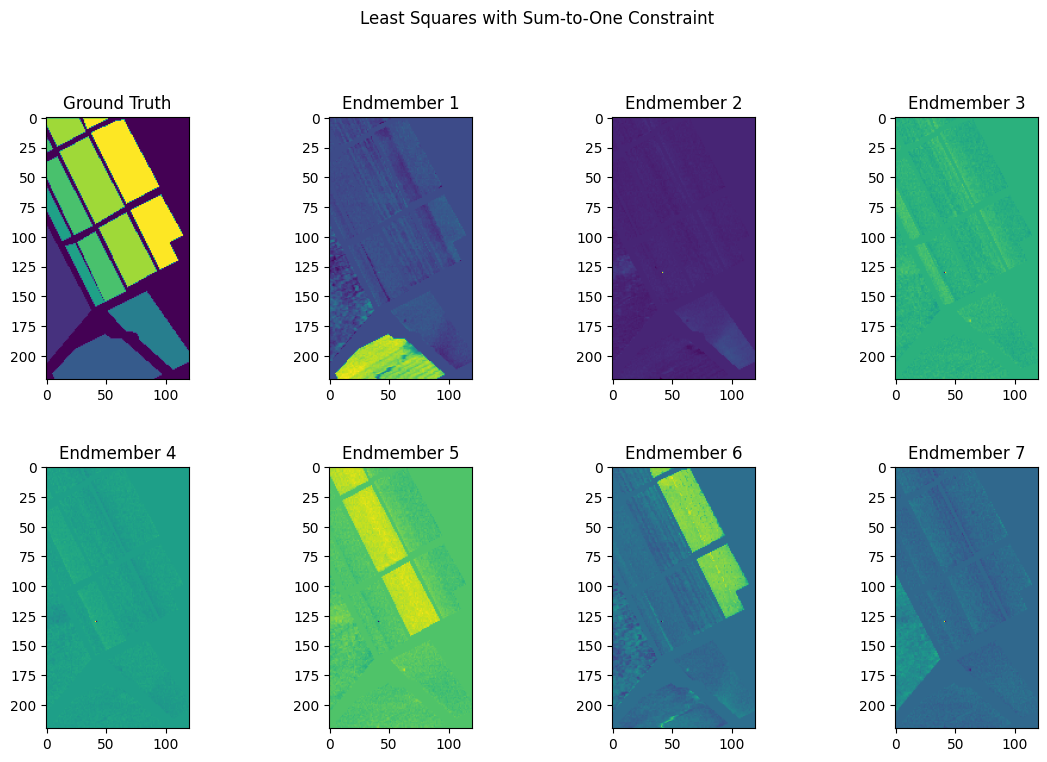

In [14]:
_ = plot_abundance_maps(STO_Thetas, 'Least Squares with Sum-to-One Constraint', X_NZ, Y_NZ)

##### *Get the reconstruction error*

In [15]:
STO_Rec_Error = get_reconstruction_error(NZ_HSI, endmembers, labels, STO_Thetas)

print(f'LS Sum-to-One - Reconstruction Error: {STO_Rec_Error}')

LS Sum-to-One - Reconstruction Error: 43082.57630278131


### *(c) Least Squares imposing the non-negativity constraint on the entries of θ*

In *mathematical optimization*, the problem of **non-negative least squares (NNLS)** is a type of *regularized least squares (RLS)* problem where the coefficients are not allowed to become negative. To achieve that we need to solve the following problem:

$$ \text{argmin}_{\theta} J(\theta), \phantom{o} \text{where} \phantom{o} J(\theta) = \lVert y - X \theta \rVert^2, \phantom{o} \text{subject to} \phantom{o} \theta \geq 0 $$

##### *Get the theta estimates*

In [16]:
def NNLS_Optimizer(c, endmembers, image):      
    for i in range(c):  
        # Use scipy's nnls function to perform non-negative least squares optimization
        theta, _ = scipy.optimize.nnls(endmembers, image[i, :])
        # Yield the optimized theta values
        yield theta

In [17]:
NNLS_Thetas = np.array([*NNLS_Optimizer(np.count_nonzero(labels), endmembers, NZ_HSI)]).T

##### *Get the abundance maps (one for each endmember)*

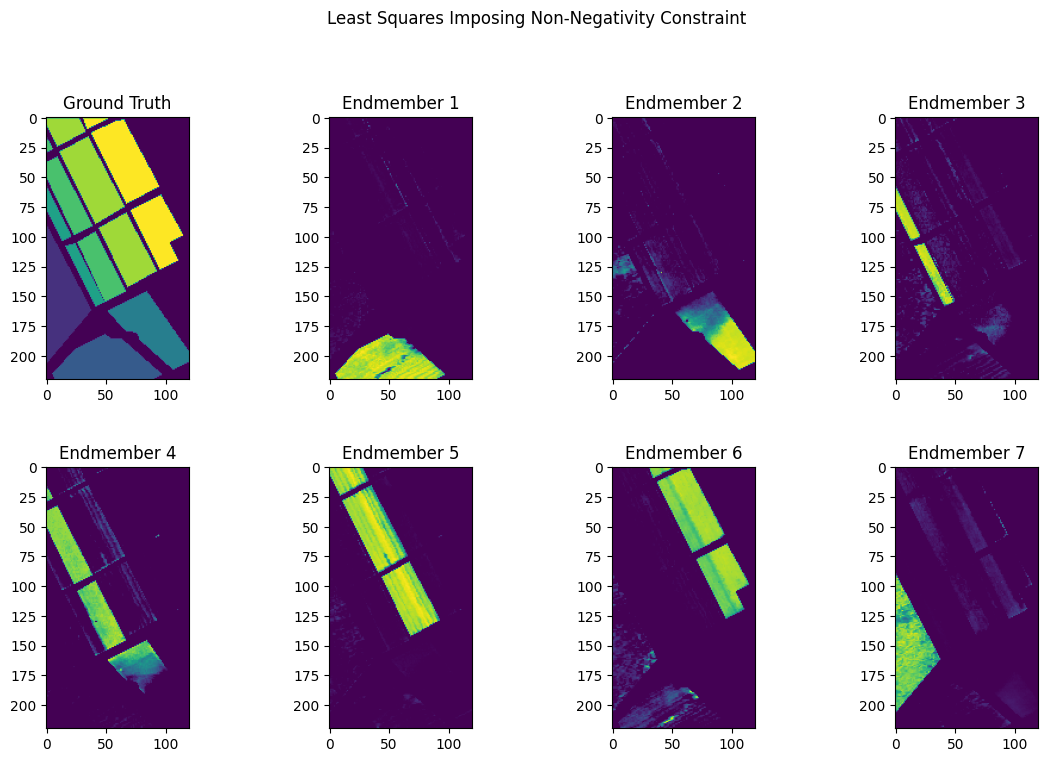

In [18]:
_ = plot_abundance_maps(NNLS_Thetas, 'Least Squares Imposing Non-Negativity Constraint', X_NZ, Y_NZ)

##### *Get the reconstruction error*

In [19]:
NNLS_Rec_Error = get_reconstruction_error(NZ_HSI, endmembers, labels, NNLS_Thetas)

print(f'LS Non_Negativity - Reconstruction Error: {NNLS_Rec_Error}')

LS Non_Negativity - Reconstruction Error: 156104.18220644665


### *(d) Least Squares imposing both the non-negativity and the sum-to-one constraint on the entries of θ*

Here we will combine ***both*** the *non-negativity* and the *sum-to-one* constraint on the entries of $θ$. To achieve that we need to solve the following problem:

$$ \text{argmin}_{\theta} J(\theta), \phantom{o} \text{where} \phantom{o} J(\theta) = \lVert y - X \theta \rVert^2, \phantom{o} \text{subject to} \phantom{o} \theta \geq 0 \phantom{o}\text{and}\phantom{o}  \sum_{i=1}^7 \theta_i = 1$$

##### *Get the theta estimates*

In [20]:
def STO_NN_LS_Minimizer(c,constraints, bounds, endmembers, image):
        
        initial_guess = np.ones((1, 7)) * (1/7)
        
        for i in range(c):
            
            res = scipy.optimize.minimize(
                get_euclidean_distance, 
                x0=initial_guess, 
                args=(endmembers, image[i, :]),
                bounds=bounds,
                method='SLSQP',
                tol='1e-6',
                constraints=constraints,
            )
            
            yield res.x

In [21]:
# define constraint(s)
constraints = [
        {'type': 'eq', 'fun': lambda y: 1 - np.sum(y)}
]
bounds = [(0, None)] * endmembers.shape[1]

# Obtain the results from the minimization process as a transposed array
STO_NN_Thetas = np.array([*STO_NN_LS_Minimizer(np.count_nonzero(labels),constraints, bounds,endmembers,NZ_HSI)]).T

##### *Get the abundance maps (one for each endmember)*

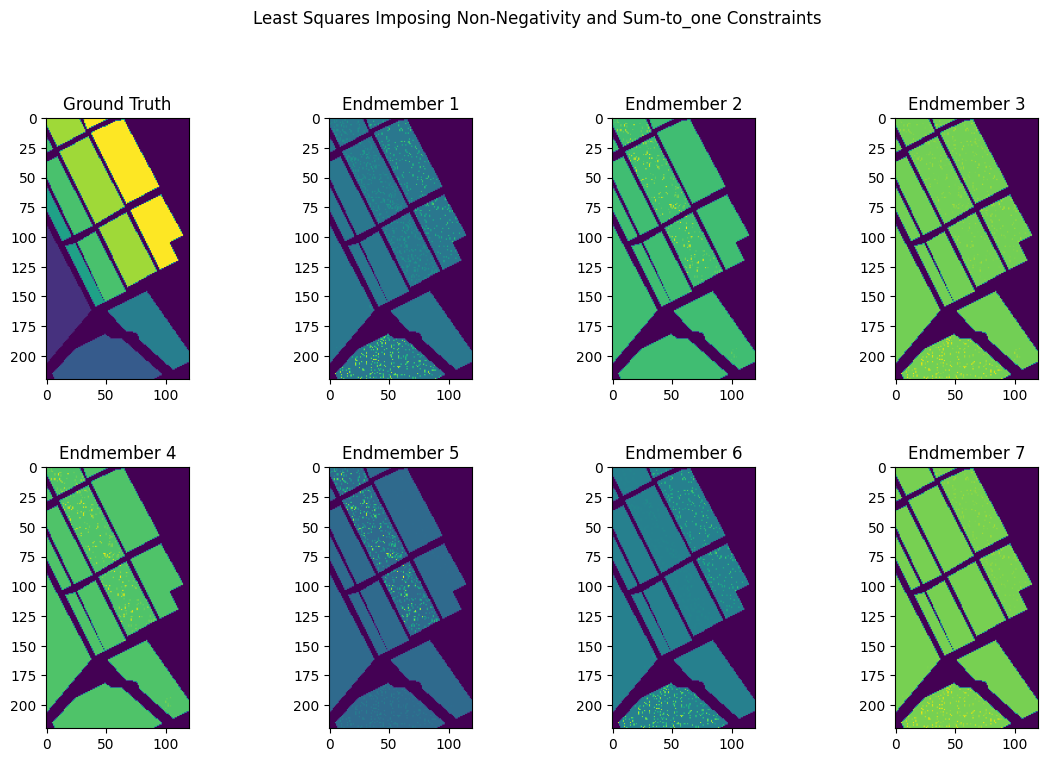

In [22]:
_ = plot_abundance_maps(STO_NN_Thetas, 'Least Squares Imposing Non-Negativity and Sum-to_one Constraints', X_NZ, Y_NZ)

##### *Get the reconstruction error*

In [23]:
STO_NN_Rec_Error = get_reconstruction_error(NZ_HSI, endmembers, labels, STO_NN_Thetas)

print(f'LS Non-Negativity and Some-to-One - Reconstruction Error: {STO_NN_Rec_Error}')

LS Non-Negativity and Some-to-One - Reconstruction Error: 83586219.23952918


### *(e) LASSO, i.e., impose sparsity on θ via L1 norm minimization* 

In this approach we will solve the following problem:

$$ \text{argmin}_{\theta} J(\theta), \phantom{o} \text{where} \phantom{o} J(\theta) = \lVert y - X \theta \rVert^2, \phantom{o} \text{subject to} \phantom{o} \lVert \theta \rVert_1 \leq \rho $$

##### *Get the theta estimates*

In [24]:
def LASSO_Optimizer(c, model, endmembers, image):  
    for i in range(c):    
        model.fit(endmembers, image[i, :])
        yield model.coef_

In [28]:
# initialise the lasso regression model
ls_model = Lasso(alpha=0.01, positive=True, fit_intercept=False, max_iter=1e7)

#get thetas
LASSO_Thetas = np.array([*LASSO_Optimizer(np.count_nonzero(labels),ls_model,endmembers, NZ_HSI)]).T

##### *Get the abundance maps (one for each endmember)*

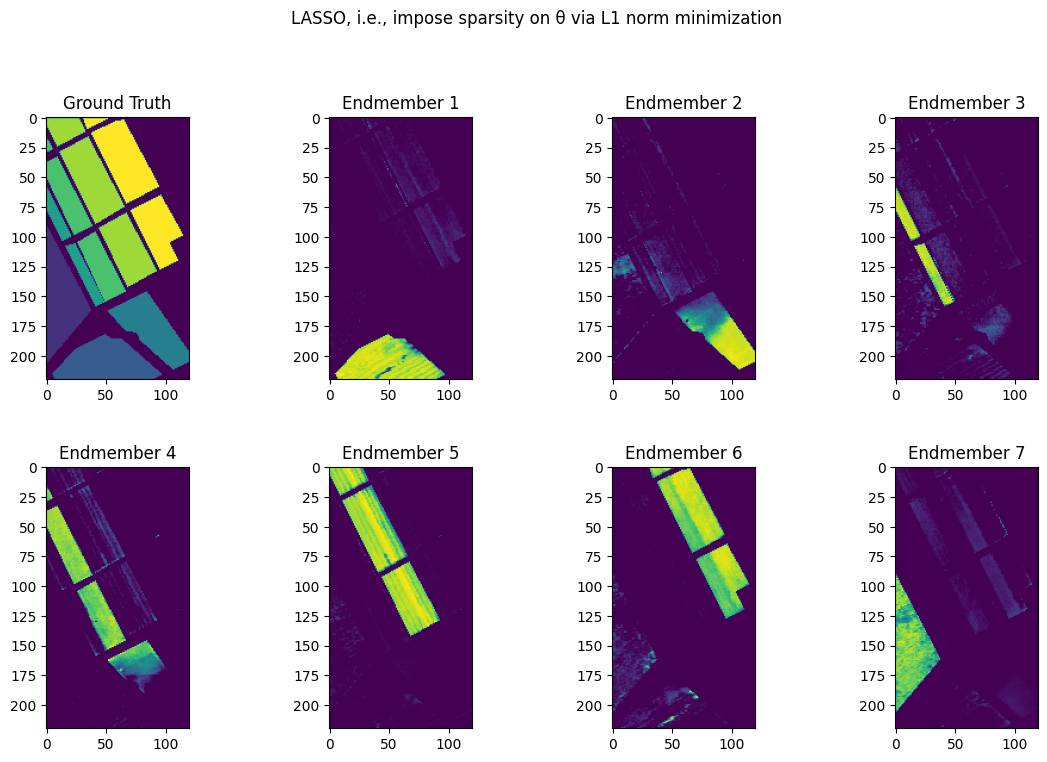

In [30]:
_ = plot_abundance_maps(LASSO_Thetas, 'LASSO, i.e., impose sparsity on θ via L1 norm minimization', X_NZ, Y_NZ)

##### *Get the reconstruction error*

In [29]:
LASSO_Rec_Error = get_reconstruction_error(NZ_HSI, endmembers, labels, LASSO_Thetas)

print(f'LASSO - Reconstruction Error: {LASSO_Rec_Error}')

LASSO - Reconstruction Error: 158007.10768225134


### *Compare Results* 

##### *Plot the reconstruction errors*

In [41]:
#Reconstruction Errors List
Rec_Errors = [LS_Rec_Error, STO_Rec_Error, NNLS_Rec_Error, STO_NN_Rec_Error, LASSO_Rec_Error]

#Methods List
Methods = ['LS', 'LS (sum-to-one)', 'LS (non-negative)', 'LS (non-negative and sum-to-one)', 'Lasso']

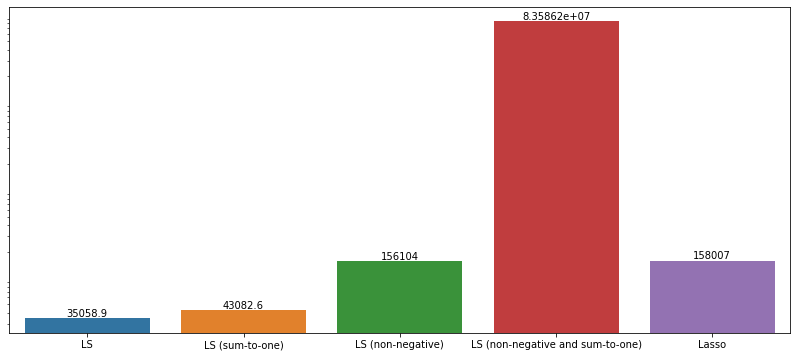

In [58]:
plt.figure(figsize = (14,6))

ax = sns.barplot(x = Methods,y = Rec_Errors)
ax.bar_label(ax.containers[0])
plt.xlabel(None)
plt.ylabel(None)
plt.yscale('log')
plt.yticks([])
plt.show()

##### *Plot Materials derived from each method against the Ground Truth*

In [65]:
def get_full_image(image, x, y):
    
    temp = np.zeros((225, 130))

    temp[x, y] = image
    
    return temp

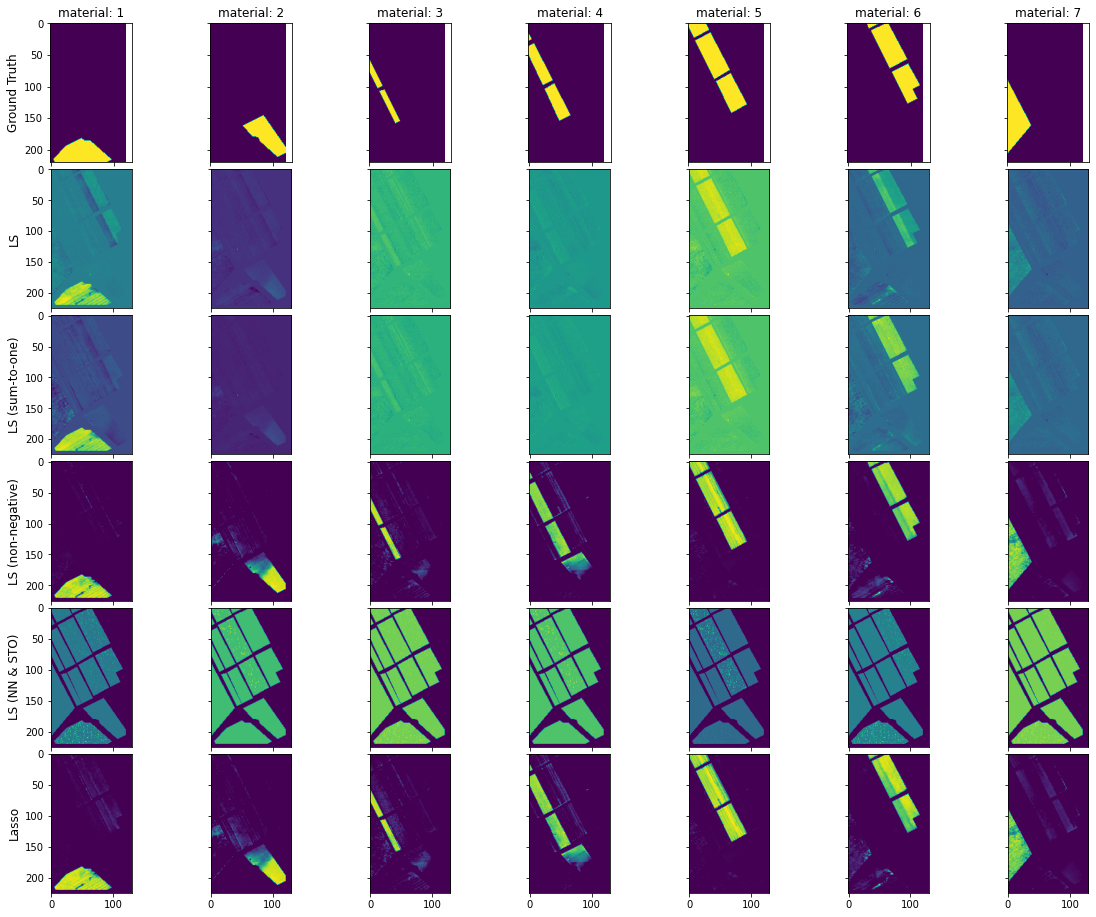

In [92]:
plotset = ['Ground Truth','LS', 'LS (sum-to-one)', 'LS (non-negative)', 'LS (NN & STO)', 'Lasso']

fig, axs = plt.subplots(6, 7, figsize=(20, 16), facecolor='w', edgecolor='k', sharex='col', sharey='row')

fig.subplots_adjust(hspace=.3, wspace=.001)

for i in range(7):
    
    # ground-truth
    axs[0,i].imshow(np.array(labels == (i + 2 if i + 2 != 8 else 1)).reshape(220,120))

    # LS approaches
    axs[1, i].imshow(get_full_image(LS_thetas[i, :], X_NZ, Y_NZ))
    axs[2, i].imshow(get_full_image(STO_Thetas[i, :],X_NZ, Y_NZ))
    axs[3, i].imshow(get_full_image(NNLS_Thetas[i, :], X_NZ, Y_NZ))
    axs[4, i].imshow(get_full_image(STO_NN_Thetas[i, :], X_NZ, Y_NZ))
    axs[5, i].imshow(get_full_image(LASSO_Thetas[i, :], X_NZ, Y_NZ))
    
    axs[0,i].set_title('material: {}'.format(i + 1), rotation=0, size='large')
    
    if i < 6:
        axs[i, 0].set_ylabel(plotset[i], rotation=90, size='large')
            

plt.subplots_adjust(wspace=0, hspace=0.05)

##### *Comments*

The ideal approach for spectral unmixing should produce abundance maps where each map exclusively includes the pixels corresponding to its specific class. In our examination, a clear distinction arises when comparing the outcomes of various methods. Notably, Non-Negative Least Squares (LS) and Least Absolute Shrinkage and Selection Operator (LASSO) display significantly superior performance in material separation. However, the story shifts entirely when assessing the reconstruction error for each method. Ordinary Least Squares (OLS) demonstrates the lowest reconstruction error, whereas both Non-Negative LS and LASSO exhibit notably poorer performance.

This phenomenon can potentially be explained. Solving least squares methods involving inequality constraints and regularization poses a significantly greater challenge as a minimization problem compared to those with equality constraints or no constraints at all. Consequently, this suggests that the reconstruction error might not be the most reliable metric for measuring spectral unmixing performance. It implies that the abundance maps obtained from constrained LS methods offer a more accurate representation of the actual data.

## Part 2

## Classification


In this case, we **consider** also the image **pixels** with **non-zero class labels**. The task is to assign each one of them to the most appropriate class, among the ***7 known classes (endmembers)***. To this end, four classifiers will be used:

- The *Naive Bayes* classifier
- The *Minimum Euclidean Distance* classifier
- The *K-Nearest Neighbor* classifier
- The *Bayesian Classifier*

For each one of them the ***same training***, ***test*** and ***operational*** sets will be used. Note that, ***in practice***, we have at our disposal a set of points which we split into the training and the test set. The operational set mentioned above corresponds to data presented to the classifiers ***after*** their training and evaluation, that is, during their operational mode.

For **each classifier:**
   - (a) Train it based on the training set performing a 10-fold cross validation
   - (b) Report the estimated validation error as the mean of the ten resulting error values
   - (c) Compute, also, the associated standard deviation
   - (d) After that, use the whole training set to train the classifier and evaluate their performance on the test set as follows:
       - Compute the **confusion matrix**
       - Compute the **success rate** of the classifier (sum of the diagonal elements of the confusion matrix and divide by the sum of all elements of the matrix)

##### *Read the data for Part 2 - Classification*

In [5]:
# Salinas labels - Train, Test and Operational set
Salinas_labels = sio.loadmat('./data/classification_labels_Salinas.mat')
Training_Set = (np.reshape(Salinas_labels['training_set'],(120,220))).T
Test_Set = (np.reshape(Salinas_labels['test_set'],(120,220))).T
Operational_Set = (np.reshape(Salinas_labels['operational_set'],(120,220))).T

##### *Datasets Visualization*

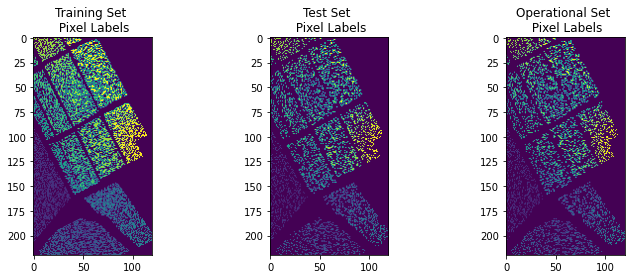

In [7]:
# create the figure
fig, ax = plt.subplots(1,3,figsize=(12,4))
# labels - train set
ax[0].imshow(Training_Set)
ax[0].set_title('Training Set \n Pixel Labels')
# labels - test set
ax[1].imshow(Test_Set)
ax[1].set_title('Test Set \n Pixel Labels')
# labels - operational set
ax[2].imshow(Operational_Set)
ax[2].set_title('Operational Set \n Pixel Labels')
plt.show()

##### *Define x,y sets*

In [12]:
#train
x_train = HSI[Training_Set != 0]
y_train = Training_Set[Training_Set != 0]

#test
x_test = HSI[Test_Set != 0]
y_test = Test_Set[Test_Set != 0]

#operational
x_op = HSI[Operational_Set != 0]
y_op = Operational_Set[Operational_Set != 0]

### *Naive Bayes* 

##### *Mean Validation Error and Standard Deviation*

In [14]:
# 10 K-Fold Stratification
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)

#model
model = GaussianNB()

# calculate the score for the 10-fold stratified cross validation
scores = cross_validate(model, x_train, y_train, scoring=['accuracy'], cv=cv)

# error
error_nb = 1 - scores['test_accuracy'].mean()

#standard deviation
stdev_nb = np.std(scores['test_accuracy'])

print(f'Mean Error:         {error_nb}')
print(f'Standard Deviation: {stdev_nb}')

Mean Error:         0.018428831001364943
Standard Deviation: 0.005235750005192638


##### *Confusion Matrix*

In [15]:
# fit the model
model.fit(x_train, y_train)

# make predictions
nb_preds = model.predict(x_test)

# confusion matrix
confusion_matrix(y_test, nb_preds)

array([[545,   0,   0,   0,   0,   0,   3],
       [  5, 512,   0,   0,   0,   0,   0],
       [  0,   0, 470,   0,  42,   0,   0],
       [  0,   0,   0, 210,   4,   0,   0],
       [  0,   0,  12,   4, 547,   0,   0],
       [  1,   0,   2,   0,   0, 995,   0],
       [  6,   0,   0,   0,   0,   0, 874]], dtype=int64)

##### *Success Rate*

In [16]:
# compute the success rate
nb_success_rate = np.trace(confusion_matrix(y_test, nb_preds)) / np.sum(confusion_matrix(y_test, nb_preds))

# display the result
print(f'Naive Bayes - Success Rate: {nb_success_rate}')

Naive Bayes - Success Rate: 0.9813327032136105


### *Minimum Euclidean Distance Classifier*

##### *Define Corresponding Class*

In [29]:
class MEDC(BaseEstimator):
    """
    Implements a minimum Euclidean distance classifier.
    
    Attributes:
        fit: Given X and y, fits the classifier on the data.
        predict: Given X, returns the predictions.
    """

    def __init__(self):
        self.classes_num = None
        self.classes_mean = None

    def __str__(self):
        return "Bayes classifier"

    @staticmethod
    def euclidean_distance(arr1, arr2):
        """
        Returns the Euclidean distance between two arrays.
        """
        diff = arr1 - arr2
        return np.dot(diff, diff)
        
    def fit(self, X, y):
        """
        Fits the classifier on the data.

        Parameters:
        X (array): Input data.
        y (array): Target values.

        Returns:
        self: Returns an instance of the classifier.
        """

        self.classes_num = len(np.unique(y))
        m, n = X.shape
        self.classes_mean = np.zeros((self.classes_num, n))

        for i in range(self.classes_num):
            self.classes_mean[i] = np.mean(X[y == i + 1], axis=0)

        return self
    
    def predict(self, X):
        """
        Returns the predictions for the input data.

        Parameters:
        X (array): Input data.

        Returns:
        array: Predicted target values.
        """

        m, _ = X.shape
        y_pred = np.zeros(m)

        if self.classes_num is None:
            raise ValueError("fit() was not called before predict() - aborting.")

        for i in range(m):
            dist = np.zeros(self.classes_num)

            for j in range(self.classes_num):
                dist[j] = self.euclidean_distance(X[i], self.classes_mean[j])

            y_pred[i] = np.argmin(dist) + 1.0

        return y_pred


##### *Mean Validation Error and Standard Deviation*

In [30]:
# select model
model = MEDC()

# calculate the score for the 10-fold stratified cross validation
scores = cross_validate(model, x_train, y_train, scoring=['accuracy'], cv=cv)

# error
error_MEDC = 1 - scores['test_accuracy'].mean()

# standard deviation
stdev_MEDC = np.std(scores['test_accuracy'])

print(f'        Mean Error: {error_MEDC}')
print(f'Standard Deviation: {stdev_MEDC}')

        Mean Error: 0.04418361565363482
Standard Deviation: 0.0066553156011937425


##### *Confusion Matrix*

In [31]:
# fit the model
model.fit(x_train, y_train)

# make predictions
MEDC_preds = model.predict(x_test)

# confusion matrix
confusion_matrix(y_test, MEDC_preds)

array([[536,   0,   4,   0,   1,   0,   7],
       [  2, 484,   0,   0,   0,   0,  31],
       [  0,   0, 417,   0,  95,   0,   0],
       [  0,   0,   0, 212,   2,   0,   0],
       [  0,   0,  16,   4, 543,   0,   0],
       [  0,   0,   6,   0,   0, 992,   0],
       [  5,   0,   0,   0,   0,   0, 875]], dtype=int64)

##### *Success Rate*

In [32]:
# compute the success rate
MEDC_success_rate = np.trace(confusion_matrix(y_test, MEDC_preds)) / np.sum(confusion_matrix(y_test, MEDC_preds))

# display the result
print(f'Naive Bayes - Success Rate: {MEDC_success_rate}')

Naive Bayes - Success Rate: 0.9591209829867675


### *KNN*

##### *Mean Validation Error and Standard Deviation*

In [33]:
# model
model = KNeighborsClassifier(n_neighbors=5)

# calculate the score for the 10-fold stratified cross validation
scores = cross_validate(model, x_train, y_train, scoring=['accuracy'], cv=cv)

# calculate the error
error_knn = 1 - scores['test_accuracy'].mean()

# calculate the standard deviation
stdev_knn = np.std(scores['test_accuracy'])

print(f'        Mean Error: {error_knn}')
print(f'Standard Deviation: {stdev_knn}')

        Mean Error: 0.006733960215584922
Standard Deviation: 0.003129295611041255


##### *Confusion Matrix*

In [34]:
# fit the model
model.fit(x_train, y_train)

# make predictions
knn_preds = model.predict(x_test)

# confusion matrix
confusion_matrix(y_test, knn_preds)

array([[547,   0,   0,   0,   0,   0,   1],
       [  0, 516,   0,   0,   0,   0,   1],
       [  0,   0, 510,   0,   2,   0,   0],
       [  0,   0,   0, 213,   1,   0,   0],
       [  0,   0,   8,   1, 552,   2,   0],
       [  0,   0,   0,   0,   0, 998,   0],
       [  0,   1,   0,   0,   0,   0, 879]], dtype=int64)

##### *Success Rate*

In [35]:
# compute the success rate
knn_success_rate = np.trace(confusion_matrix(y_test, knn_preds)) / np.sum(confusion_matrix(y_test, knn_preds))

# display the result
print(f'Naive Bayes - Success Rate: {knn_success_rate}')

Naive Bayes - Success Rate: 0.9959829867674859


### *Bayesian Classifier* 

##### *Mean Validation Error and Standard Deviation*

In [36]:
# select model
model = QuadraticDiscriminantAnalysis()

# calculate the score for the 10-fold stratified cross validation
scores = cross_validate(model, x_train, y_train, scoring=['accuracy'], cv=cv)

# calculate the error
error_bc = 1 - scores['test_accuracy'].mean()

# calculate the standard deviation
stdev_bc = np.std(scores['test_accuracy'])

print(f'        Mean Error: {error_bc}')
print(f'Standard Deviation: {stdev_bc}')

        Mean Error: 0.031186415132256506
Standard Deviation: 0.0071305597756732035


##### *Confusion Matrix*

In [37]:
# fit the model
model.fit(x_train, y_train)

# make predictions
bc_preds = model.predict(x_test)

# confusion matrix
confusion_matrix(y_test, bc_preds)

array([[548,   0,   0,   0,   0,   0,   0],
       [  0, 517,   0,   0,   0,   0,   0],
       [  0,   0, 512,   0,   0,   0,   0],
       [  0,   0,   0, 125,  89,   0,   0],
       [  0,   0,   3,   0, 558,   2,   0],
       [  0,   0,   0,   0,   0, 998,   0],
       [  0,   0,   0,   0,   0,   0, 880]], dtype=int64)

##### *Success Rate*

In [38]:
# compute the success rate
bc_success_rate = np.trace(confusion_matrix(y_test, bc_preds)) / np.sum(confusion_matrix(y_test, bc_preds))

# display the result
print(f'Naive Bayes - Success Rate: {bc_success_rate}')

Naive Bayes - Success Rate: 0.9777882797731569


### *Compare Results* 

In [41]:
reconstruction_errors = [error_nb, error_MEDC, error_knn, error_bc]
success_rates = [nb_success_rate, MEDC_success_rate, knn_success_rate, bc_success_rate]

classifiers = ['Naive Bayes Classifier','Minimum Euclidean Distance Classifier','KNN Classifier','Bayesian Classifer']

##### *Plot the errors and the success rates*

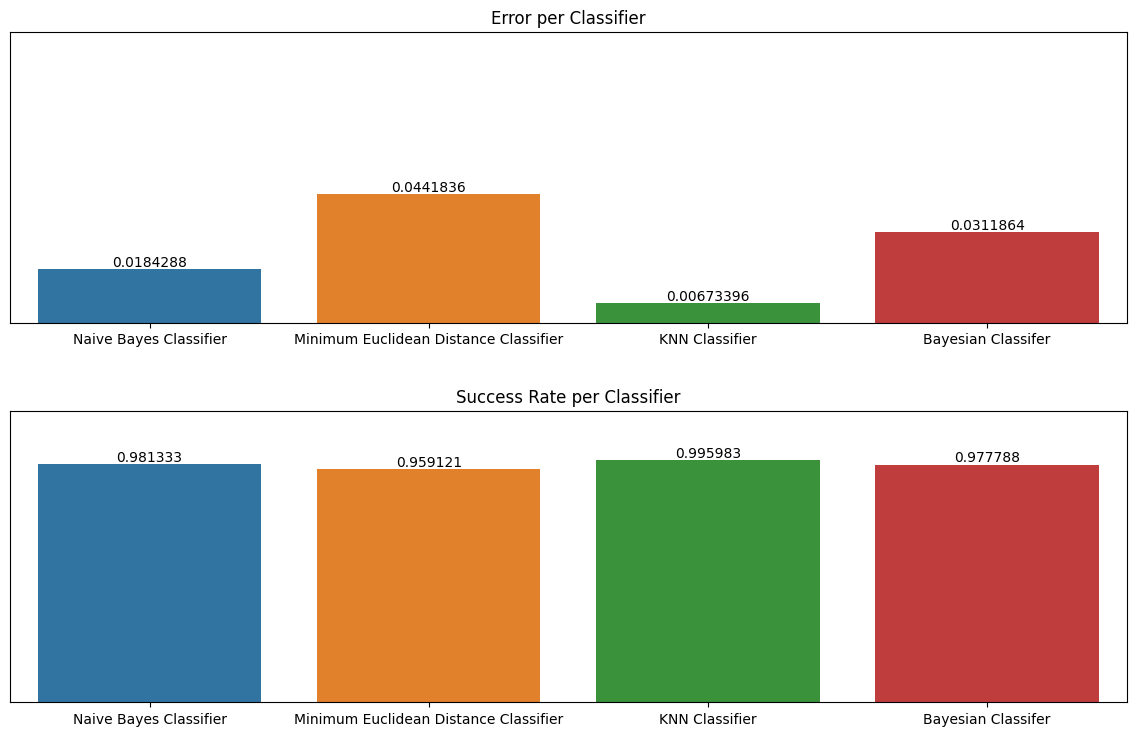

In [44]:
fig, ax = plt.subplots(2,1,figsize=(12,8),dpi=100,facecolor='white')

# plot errors
ax1 = sns.barplot(x=classifiers, y=reconstruction_errors, ax=ax[0])
ax1.bar_label(ax1.containers[0])
ax[0].set_xlabel(None)
ax[0].set_ylabel(None)
ax[0].set_ylim(0,0.1)
ax[0].set_yticks([])
ax[0].set_title('Error per Classifier')

# plot success rates
ax2 = sns.barplot(x=classifiers, y=success_rates, ax=ax[1])
ax2.bar_label(ax2.containers[0])
ax[1].set_xlabel(None)
ax[1].set_ylabel(None)
ax[1].set_ylim(0,1.2)
ax[1].set_yticks([])
ax[1].set_title('Success Rate per Classifier')

plt.tight_layout(pad=3)
plt.show()

##### *Comments*

- When comparing the outcomes from all classifiers, noticeable disparities exist in their respective errors.
- Nevertheless, a comparison of their success rates reveals that their performances are almost equivalent.
- Thus, considering both their errors and success rates, a distinct winner emerges.
- The K-Nearest Neighbors (KNN) classifier not only demonstrates the highest overall success rate but also exhibits the lowest error, significantly surpassing the second-ranked classifier.
- Conversely, the Minimum Euclidean Distance classifier appears to be the least effective performer.
- It is evident from the provided graph that it ranks last in both error rate and success rate.
- The same conclusion can be drawn by examining its confusion matrix.
- It is noticeable that it contains more non-diagonal values compared to the other classifiers, indicating a higher occurrence of misclassified data.

## Conclusion

Certainly! Here is the rephrased version of the text:

In this project, we focused on processing hyperspectral images, undertaking tasks related to spectral unmixing and classification. In the initial phase of spectral unmixing, we applied various least squares methods, including both ordinary and regularized techniques, to estimate the relationship between the 7 endmembers and the spectral signature of each pixel in the image. For the classification phase, we utilized four distinct classification algorithms to predict the class to which each pixel in the provided test set belongs.

Following the completion of both tasks, we identified a noticeable correlation between the results derived from the spectral unmixing process and those obtained from the classification process. By generating abundance maps for each endmember, our aim was to classify each pixel into one of the 7 endmember classes. Thus, through the derivation of these abundance maps, we sought to illustrate the spatial allocation of each of the 7 endmembers (materials) within the image, effectively indicating their positioning on the ground.